# Session 4: Spring 2026

Big Data Algorithms

## Outline

- Exercise on AND-OR construction

Review/Completion/Exercises from the last session:

-   Reservoir Sampling
-   Counting unique items: the FM Algorithm

This week:

- Identifying heavy hitters
- Alon-Matias-Szegedy algorithm for calculating moments
- Bloom Filters
- The Count-Min Sketch

## Formative Exercise

The AND-OR construction for $n = b \cdot r$ hash signatures with $b$ bands and $r$ rows per band is analyzed as follows. Consider any two distinct documents with similarity $s$ where $0 \leq s \leq 1$:

1. Prob. that they have identical signatures in a band is \_\_\_
2. Prob. that their signatures differ somewhere in a band is \_\_\_
3. Prob. that they differ somewhere in **all** bands is |_\_\_

Hence, the pairing probability that they agree all all rows of some band = \_\_\_

## Normative Exercise (blue book)

Suppose we start with the AND-OR construction using $b$ bands and $r$ rows per band. Consider two situations:

1. The number of bands increases to $b+1$ but the number of rows per band stays at $r$
2. The number of bands stays at $b$ but the number of rows per band increases to $r+1$

For each of these situations separately, explain carefully whether the original false positive and false negative probabilities increase or decrease when the AND-OR construction is applied. 


In [6]:
import numpy as np
import pandas as pd
import sklearn
import hash_family

rng = np.random.default_rng()

## Hamming Distance

Distance between 0/1-valued (binary) vectors of length $n$

-   equals the number of bit positions that differ, or can also be
    defined as the *fraction* of bit positions that differ; i.e., it is
    integer-valued between 0 and $n$ (when un-normalized) or $\leq 1$
    (when normalized by $n$).

-   it is a metric distance

## LSH Family for Hamming Distance

-   Data consists of $n$ dimensional **binary** vectors with positions
    indexed from 0 through $(n-1)$.

-   A “hash function” in the family corresponds to a *projection*: the
    projection $h_i$ for $0 \leq i \leq n-1$ extracts the $i^{th}$
    (least significant) bit of a vector.

*Normalized* Hamming distance $\implies$
$(d_1, d_2, (1- \frac{d_1}{n}), (1-\frac{d_2}{n}))$-sensitive family.

## Euclidean Distances

-   $L_1$ distance (also called **Manhattan distance**):

$L_1(p,q) = \sum_{i=0}^{n} |p_i - q_i|$

-   $L_k$ distance: (the $k=2$ case is the familar distance norm)

$L_k(p, q) = \sqrt[k]{\sum_{i=0}^{n-1} |p_i - q_i|^k}$

-   $L_{\infty}$ distance:

$L_{\infty}(p, q) = max_{i} |p_i - q_i|$

## Example: LSH family for Euclidean $L_2$ distance

-   Data is a collection of $2$-dimensional points

-   A “hash function” in the family corresponds to a **random line**
    that is divided into numbered segments (**buckets**) of length $a$

-   The hash application is the bucket number reached when a
    **perpendicular** is dropped from the point onto the line!

> This yields a $(\frac{a}{2}, 2a, \frac{1}{2}, \frac{1}{3})$-sensitive
> hash family.

## Geometric interpretation (in 2D)

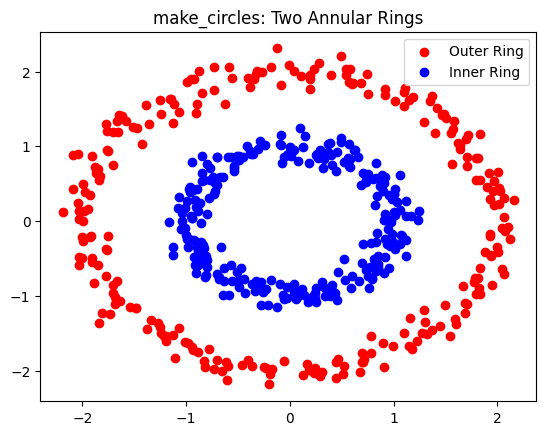

In [2]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generate the two annular rings
X, y = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)
X = 2*X

# Plotting
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Outer Ring')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Inner Ring')
plt.title("make_circles: Two Annular Rings")
plt.legend()
plt.show()


In [7]:
v = rng.normal((2, 1))

In [ ]:
v

In [8]:
v/np.linalg.norm(v)

array([0.99259682, 0.12145597])

In [5]:
X[y==0][10:30]

array([[ 1.15295542, -1.67364432],
       [-1.66708568,  1.33701   ],
       [-0.7038165 , -1.86038484],
       [ 1.97163214,  0.21883687],
       [-0.26869338,  1.98832303],
       [ 0.99714219, -1.66920918],
       [-0.00651085,  2.08246114],
       [-1.62126627,  1.40546437],
       [-0.19801442, -2.18363132],
       [ 1.29324547,  1.3258288 ],
       [-0.55380799,  1.91582208],
       [ 2.06475581,  0.05360265],
       [ 2.00807246,  0.65923807],
       [ 1.61729559,  1.0458243 ],
       [-0.72943219,  2.05753605],
       [-0.4652553 , -1.92101352],
       [-1.99411057, -0.27193365],
       [ 0.22839283, -2.03654097],
       [ 0.285039  ,  2.1171575 ],
       [-1.63836514, -1.07183901]])

In [ ]:
Z = 

In [16]:
Z[:, 0]

TypeError: 'int' object is not subscriptable

In [12]:
c = Z.dot(v/np.linalg.norm(v)) // 1
c

np.float64(1.0)

In [11]:
plt.scatter(Z[:, 0], Z[:, 1], c=c, cmap='viridis')
plt.axline(xy1=v, slope=v[1]/v[0], color='r', linestyle='--')
plt.title("Signatures")
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Data Structures/Algorithms for Data Streams

Very large volumes of data that requires *immediate* (real-time)
processing or is too large to be *analyzed in time* from archives.

-   Sensor data (e.g. weather information, or sensors used in IOT
    applications)

-   Satellite data

-   Data involved in cyber-security, e.g. IP traffic on a router

-   Stock price fluctuations

-   Identifying frequent search queries

-   Identifying popular products

## Data Summaries and Sampling

We often need:

-   statistical information about *sliding windows*

-   extraction of *representative* or *reliable* samples: subset
    selection

-   filters to select samples

-   approximate counts of distinct elements

In all these applications, **hashing** is the key!

## Reservoir Sampling

We wish to choose a subset (the reservoir) of size $k<<N$ from a data stream of *unknown* size $N$.

Desired prob. for item to be in reservoir $=k/N$ (i.e., **uniformly
drawn sample** had we known $N$).

Algorithm:

-   Store first $k$ items in the reservoir

-   Item $i>k$ replaces $j^{th}$ **item in reservoir** if $j$ is the random
    choice among $[1,i]$ (and of course, $j <= k$); otherwise, discard item $i$.

> **Exercise:** Prove that reservoir sampling works!

## Proof of Reservoir Sampling

We don't know $N$! So all we can do is ensure that:

> After seeing the first $m \geq k$ items, the probability that
> any of those items is in the reservoir is $\frac{k}{m}$

- Initially (i.e., when $m = k$):

- Hypothesis: Correct after $m$ items.

- Inductive step: what happens after processing $I_{m+1}$?

    - Prob. that $I_{m+1}$ is discarded
    - Prob. that $I_{m+1}$ enters the reservoir


## Counting Distinct Elements

> Count (approximately) the number of **unique** elements, $m$, in a
> stream.

-   Very large universal set

-   Traditional in-core data structure like a hash table or a balanced
    search tree is impossible due to space or time constraints.

-   But hashing offers a clue: the wider the range (image) of the hash,
    the more likely it is that distinct elements will hash to
    *distinctive values*.

## Flajolet-Martin Algorithm

Choose a hash function family that maps elements to bit strings of a
certain length (ensure that range is much larger than the domain).

-   Pick **many hash functions** and apply them to every element.

-   **Intuition:**

    -   More distinct items $\implies$ more distinct hash values!

    -   For each hash function, count special bit patterns in the image.

-   Special pattern: long stretches of trailing zero bits

## Estimating $m$

**Tail length:** For element $a$ and hash function $h$, the tail length

$t_{h}(a) = \mbox{number of trailing zeros in }h(a)$.

-   $R_h$: maximum tail length seen with hash function $h$

-   Estimate of $m$ (according to $h$) is $2^{R_h}$.

-   **Note:** Prob. that $t_h(a)$ is *at least* $r$ is $2^{-r}$.

## Justification

Suppose that $R_h$ is the current (maximum) tail length and $m$ distinct
elements. Is $2^{R_h}$ a good estimate of $m$?

-   Prob. that an element has $<r$ tail length $= (1 -
      2^{-r})$

-   Prob. that all have this property $=(1-2^{-r})^m$, i.e.
    $\approx e^{-m2^{-r}}$.

-   Prob. that at least one has tail length $>=r$ is $p=1 -
      e^{-m2^{-r}}$.

But $p \rightarrow 1$ (resp. $0$) if $m >> 2^{r}$ (resp. $m << 2^{r}$).

## Why Use Many Hashes

-   To even out the estimates, e.g. by averaging the estimates from
    different hash functions

-   Overestimates, in this case, can be problematic: small probability
    for $R_h$ increasing by one but estimate doubles!

-   Solution:

    -   Form large groups of hash functions, with each group large
        enough

    -   Use the medians of the means within groups.

    -   Space $=$ one tail length per function; elements not stored!

## Exercise (Submit code on canvas)

**Data:** Create a sample of size 1000000 drawn from a geometric distribution with
probability $p=0.15$ of success.

Simulate the Flajolet-Martin algorithm on the random sample above, using 50 hash functions from the universal family to hash the elements.

- Group the functions into groups of 5.
- Calculate the mean estimate of the number of unique elements within each group
- Use the median of the means to return a final estimate.
- Compute the actual number of unique items and report that

Submit your work in a separate notebook on the link provided. You have 20 minutes to complete this. Complicated code that is not adequately explained, will have to be explained to me in person. 

**You must include any prompts to LLMs and the responses that were used/edited in your notebook.**

In [ ]:
import numpy as np
from hash_family import UHF

# Define the probability of success 
p = 0.15 

# Generate a single random value
single_sample = np.random.geometric(p)
print(f"Single sample: {single_sample}")

# Generate an array of 1000 samples
num_samples = 1000000
samples = np.random.geometric(p, size=num_samples)
print(f"First 10 samples: {samples[:10]}")
print(f"Mean of samples (approx 1/p): {np.mean(samples)}")

num_hashes =50
max_val = int(np.max(samples))+1
# Vectorizes the hashes
a_vals = np.rng.integers(1, max_val, size=num_hashes)
b_vals = np.rng.integers(0, max_val, size=num_hashes)

## Interlude: The Majority Element Problem

You are given an array of $n$ numbers which contains a **majority** element, i.e. one which has frequency greater than
$n // 2$. Find that element!

## Algorithm:

The algorithm always maintains a **stored element** and an **associated
counter**.

-   Store the first element and *initialize* counter to 1
-   For every subsequent element:
    -   if same as stored element, **increment** counter
    -   if different from stored element and counter is zero, replace
        stored element with new element and **initialize** counter to 1
    -   if different from stored element, **decrement** counter

## Counting most frequent elements: Heavy Hitters

Generalizes the majority element problem: one version is the **$k$-heavy
hitters** problem:

> Find the elements that have frequency at least $\frac{n}{k+1}$.

**Observation:** There can be at most $k$ such heavy hitters!

## The Algorithm (Gries-Misra)

Store upto $k$ elements, each with an associated counter. Initially,
nothing is stored and counters are zero.

For every element seen:

-   if it is currently stored, increment its counter by 1
-   if different from all stored elements, and less than $k$ elements
    are currently stored, add element with counter initialized to 1.
-   if different from all stored elements, and $k$ items currently
    stored, **decrement** each counter by 1. Remove any element from
    store if its count becomes 0 as a result.

## Analysis

Show that the reported count for each element $t$ in the store is

-   lower bounded by $f_t - \frac{n}{k+1}$
-   upper bounded by $f_t$

where $f_t$ is its actual frequency.

Hence, all heavy hitters will necessarily be stored (but there could be
non-hitters that remain in the store).

## Exercise (Submit code on canvas)

**Data:** Create a sample of size 1000000 drawn from a geometric distribution with
probability $p=0.25$ of success.

Simulate the Gries-Misra algorithm on this random sample to obtain
the $10$-heavy hitters.

Submit your work in a separate notebook on the link provided. You have 20 minutes to complete this. Complicated code that is not adequately explained, will have to be explained to me in person. 

**You must include any prompts to LLMs and the responses that were used/edited in your notebook.**


In [17]:
import numpy as np
from hash_family import UHF

# Define the probability of success 
p = 0.15 

# Generate a single random value
single_sample = np.random.geometric(p)
print(f"Single sample: {single_sample}")

# Generate an array of 1000 samples
num_samples = 1000000
samples = np.random.geometric(p, size=num_samples)
print(f"First 10 samples: {samples[:10]}")
print(f"Mean of samples (approx 1/p): {np.mean(samples)}")

num_hashes =50
max_val = int(np.max(samples))+1


Single sample: 1
First 10 samples: [ 4  9  1  4  3  5  3 19 10  1]
Mean of samples (approx 1/p): 6.673748


## Estimating Moments

Given a stream over a universal set $S={a_1,\ldots}$ of distinct
elements, let $m_i$ be the number of occurrences of $a_i$.

$k^{th}$ Moment of the stream = $\sum_{i} {m_i}^k$

-   $0^{th}$ moment (assuming the convention that $0^0 =
      0$) is just the number of distinct elements!

-   $1^{st}$ moment is the **total number** of elements in the stream.

-   Problem with higher moments: Space limitation, since we cannot keep
    exact counts of all the frequencies!

-   Let’s see how to estimate second moments.

## Alon-Matias-Szegedy Algorithm

(Temporary) Assumption: Length of stream known to be $n$

**Ingredients**:

-   Uniformly sample a small subset of positions in the stream
    (*variables* $X_i$)

-   Keep track of the frequencies ($f_i$) of the associated elements (at
    sampled positions) from the first sampled occurrence onwards.

Estimated value for second moment based on variable $X_i$ is
$(2\cdot f_i-1)\cdot n$

## Intuition

-   $c_i$ is the frequency *from position $i$ onwards* of element at
    position $i$

-   Summed over all positions $j$ where a particular element occurs, the
    value $\sum_{j} (2\cdot c_j -1)$ is the second moment for that
    element!

-   The multiplicative factor $n$ accounts for the uniform sampling.

## Hand-Written Exercise

Simulate the AMS second-moment sketch on the sequence

\[6, 4, 6, 11, 11, 4, 2, 1, 8, 8, 15, 2, 4, 7, 5, 4\]

by using the positions 1, 5, 7, 8, 11, 12 (assume that positions are
numbered from 1 through 16).

## Generalizations

-   Can handle higher-order moments $X^k$ by estimating $n(v^k
      - (v-1)^k)$ for a small collection of randomly sampled variables

-   What if $n$ is not known in advance?

    -   Just use $n$ when moments need to reported!

    -   Selection of positions can be done using reservoir sampling!

## Bloom Filters

Quick mechanism to **decide set membership** in very large sets that
*cannot* be stored in main memory, e.g. unique IP addresses whose
packets have gone through an Internet router switch.

-   A *bit vector* of size $n$

-   Set of $k$ hash functions $h_i$ mapping key values to $n$ addresses
    (buckets).

-   Set $S$ with $m < n$ *keys*.

> The Bloom filter is supposed to *reject* stream elements whose keys do not belong to $S$.

## Bloom Filter Operation

Pre-processing:

-   Initialize bit vector to all zeroes

-   For *each hash
    function* $h_i$, and every key in $S$: hash key to location in vector and **set** that bit.

Membership Check:

-   Hash key from stream to locations $h_i(\cdot)$ for $1 \leq i \leq k$.

-   If **all locations** are set, accept key; Else reject it!

Property: No false negatives!!

## False Positives

There are $k\cdot m$ hash computations during pre-processing

Consider a **specific bit**:

-   Probability that the bit remains **unset** $=(1-1/n)^{km} \approx   (e^{-1/n})^{km}$

-   Hence, probability that the bit is **set** $\approx 1 - e^{-km/n}$

-   **False positive probability (FPP)** $\approx (1-e^{-km/n})^k$

## Properties of Bloom Filters

-   Optimal number of hash functions minimizing FPP
$$\approx \frac{n}{m} \ln 2$$

-   Unlike single hash table, there is no *saturation* (i.e. Bloom
    filter never fills up; FPP just keeps increasing)

-   Can combine two Bloom filters (of the same size $n$ and the same hashes) for two sets!

    -   Union: bitwise OR; FPP same as that of filter created from
        scratch from union.

    -   Intersection: bitwise AND; FPP = maximum of FPPs of constituent filters.


## Approximate Heavy-Hitters

Recall that given $k < n$ and a very large array $A$ of size $n$, a *heavy-hitter* is an element that occurs with frequency at least $n/k$.

You are now given an additional parameter $\epsilon$, a very small value.

Gather elements from $A$ such that:

- if an element is a heavy hitter, it is gathered

- a gathered element has *actual* frequency **at least** $\frac{n}{k} - \epsilon n$



## Count-Min Sketch

Versatile, *probabilistic* data structure (like Bloom filter).

-   Vector of *actual counts* $a=(a_1, a_2, \ldots,
      a_n)$

-   Components being updated over time (assume for now only additive
    updates of the form $(i_t,x_t)$

-   Update causes $a_{i_t}$ to increase by $x_t$.

-   **Sketch** approximates this vector.

## Queries

A vector $a$ is said to be *CMS-sketched* if there is a corresponding CMS
being maintained for it. 

Query types:

-   **Point:** Estimate the value of $a_i$

-   **Inner Product:** Estimate the dot product of two vectors $a$ and
    $b$ being individually sketched.

-   **Range:** Estimate $\sum_{p=i}^{j} a_p$

## Sketch Structure for $a$

Parametrized by two small constants: $\epsilon$ (the multiplicative error
bound) and $\delta$ (the probability bound on the error).

-   Two-dimensional array with $d = \lceil \log (1/\delta)
          \rceil$ rows and $w = \lceil e/\epsilon \rceil$ columns.

-   Rows correspond to hash functions from a universal family (hence
    pairwise-independent etc.)

-   Each function hashes vector index $i$ to column $h(i)$.

-   Initially array has all 0s

-   For update $(i_t, x_t)$, add $x_t$ to the location $h_j(i_t)$ for
    *all rows* $j$.

## Query Outputs

-   **Point ($a_i$):** Return the *minimum* among all the hashed
    locations for $i$ (one per row)

-   **Inner Product ($a \cdot b$):** Minimum among dot products of
    matching rows in the sketches for $a$ and $b$

-   **Range ($a[i\ldots j]$:** Naive approach is to report the sum of
    the point queries $a_i$ through $a_j$. More sophisticated approach
    involves *dyadic ranges*.

Let $| a | = \sum_{i} a_i$, the **sum** of the counts. 

>Then, error in answering a query should be within a
>factor of $\epsilon$ with probability at least $1-\delta$.

## Analysis: Point Query $i$

**Estimate:** Return $\bar{a_i} = \min_j ~h_j(i)$.

-   Let $\bar{a_{i,j}} = h_j(i)$, the result from hash function $h_j$.  

-   $I_{j;i,k}$: indicator variable for $j^{th}$ hash function colliding
    on $i^{th}$ and $k^{th}$ components, i.e. $h_j(i)=h_j(k)$ for
    $i \not= 
      k$. 
      
> $E[I_{j;i,k}]=1/w=\epsilon/e$

Hence, $E[\bar{a_{i,j}}] \leq a_i + \epsilon \cdot | a |/e$

-   By **Markov’s inequality**, $Pr \{\bar{a_{i,j}} - a_i \geq 
      \epsilon | a | \} \leq (1/e)$

-   Using $d=\ln (1/ \delta)$ hashes, we get  

> $Pr \{ \bar{a_{i}} - a_i \geq \epsilon | a | \} \leq \delta$

## Application: Approximate k-Heavy Hitters

We combine a Count-Min Sketch with a Min-Heap!

This combination acts like a weighted reservoir. 

- The Count-Min Sketch allows you to process an infinite stream with constant memory.

- The Min-Heap ensures that at any given moment, you are holding onto the $k$ items that appear most "heavy" based on the evidence seen so far.